In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.misc import derivative as der
from scipy.special import eval_hermite as herm

In [187]:
class ODE:
    def __init__(self, f, x, psi0, dpsi0):
        self.f = f
        self.x = x 
        self.psi0 = psi0
        self.dpsi0 = dpsi0
        self.isodd = "even"
    
    #Defining Get Methods 
    def getf(self):
        return self.f
    def getx(self):
        return self.x
    def getpsi0(self):
        return self.psi0
    def getdpsi0(self):
        return self.dpsi0
    def getisodd(self):
        return self.isodd
    
    #Define add methods 
    def addisodd(self, input):
        self.isodd = input
    
    #Defining Functions 
    def detdx(self):
        x = self.getx()
        return (x[1]-x[0])
    """
    def isodd(self):
        f = self.getf()
        testx = []
        x = np.random.randint(100)
        if f(x) == f(-x):
            return "even"
        elif f(-x) == -f(x):
            return "odd"
        else:
            return "none"
    """        
    def diff(self, function, x0, dx = 1e-6, n = 1):
        return der(function, x0, dx, n)
    def psidx(self):
        dx = self.detdx()
        f = self.getf()
        psi0 = self.getpsi0()
        dpsi0 = self.getdpsi0()
        
        if self.getisodd() == 'even':
            psidx = psi0 + 0.5*(dx)**2*(f(0)*psi0)+(1/24)*(dx**4)*(self.diff(f, 0, n=2)*psi0+(2*self.diff(f,0)*dpsi0)+f(0)**2*psi0)
            #psidx = (1/24)*(dx**4)*(self.diff(f, 0, n=2)*psi0+(2*self.diff(f,0)*dpsi0)+f(0)**2*psi0)
        elif self.getisodd() == 'odd':
            psidx = dx*dpsi0 + (dx**3)*(1/6)*(f(0)*dpsi0+self.diff(f,0)*psi0)
        else:
            psidx = "Error"
        return psidx
    def solve_numerov(self):
        psi0 = self.getpsi0()
        psidx = self.psidx() 
        psi = [psi0, psidx]
        dx = self.detdx()
        f = self.getf()
        for j in range(1, len(self.x)-1):
            A1 = 2+((5/6)*dx**2*f(j*dx))
            A2 = (1-((dx**2)/12)*f((j-1)*dx))
            A3 = (1-((dx**2)/12)*f((j+1)*dx))
            
            psi.append((A1*psi[j]-A2*psi[j-1])/A3)
        return psi
    def plot_sol(self):
        x = self.getx()
        psi = self.solve_numerov()
        plt.plot(x, psi)

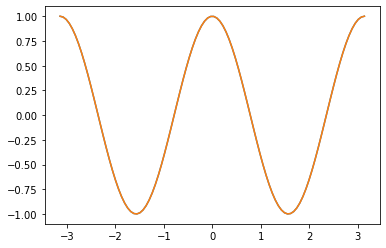

In [10]:
ode = ODE(lambda x: -4, np.linspace(-np.pi, np.pi, 100), 1, 0)
(ode.plot_sol())
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, np.cos(2*x))

In [298]:
class QMosc:
    def __init__(self, dx, x1, n , E):
        self.dx = dx
        self.x1 = x1
        self.n = n 
        self.E = E
    #Defining get methods 
    
    def getdx(self):
        return self.dx
    def getx1(self):
        return self.x1
    def getn(self):
        return self.n
    def getE(self):
        return self.E
    
    #Define change methods 
    def changeE(self, E):
        self.E = E
        
    #Other methods
    def genx(self):
        x1 = self.getx1()
        dx = self.getdx()
        x = np.arange(0, x1, dx)
        return x
    def normalize(self,list):
        return np.divide(list, max(list))
    def analytic_solve(self, x = 'default' , norm = True):
        n = self.getn()
        if x == 'default':
            x = self.genx()
        Hermite = herm(n, x)
        Exp = np.exp(-0.5*np.multiply(x, x))
        psi = Hermite*Exp
        if norm == True:
            return self.normalize(psi)
        else:
            return psi
    def numeric_solve(self, norm = True):
        E = self.getE()
        x = self.genx()
        if self.getn()%2 == 0:
            
            qmode = ODE(lambda y: y**2-E, x, 1, 0)
        else:
            
            qmode = ODE(lambda y: y**2-E, x, 0, 1)
            qmode.addisodd('odd')
        if norm == True:
            return self.normalize(qmode.solve_numerov())
        else:
            return self.normalize(qmode.solve_numerov())
    def plot_num(self, scale = 1, marker = 'o', legend = "Numerical Solution"):
        xpos = self.genx()
        psipos = self.numeric_solve()
        xneg = self.genx()*-1
        if self.getn()%2 == 0:
            psineg = self.numeric_solve()
            
        else:
            psineg = self.numeric_solve()*-1
        x = np.concatenate((xpos, xneg), axis = 0)
        psi = np.concatenate((psipos, psineg), axis = 0)
        plt.plot(x, psi*scale, marker, label = legend)
        plt.legend()
        
    def plot_an(self, scale=1, marker = '--', legend = "Analytical Solution"):
        xpos = self.genx()
        xneg = self.genx()*-1
        xtot = np.concatenate((xpos, xneg), axis = 0)
        psi = self.analytic_solve(x = xtot)
        plt.plot(xtot, psi*scale, marker, label = legend)
        plt.legend()
        
    def eigenvalue(self, e0 = 1, step = 0.01):
        self.changeE(e0)
        psi = self.numeric_solve()
        slopeinit = (psi[-1]-psi[-2])/(self.getdx())
        if slopeinit > 0:
            slope = slopeinit
            while slope > 0: 
                slope_before = slope 
                Ecurrent = self.getE()
                self.changeE(Ecurrent-step)
                psi = self.numeric_solve()
                slope = (psi[-1]-psi[-2])/(self.getdx())
                if abs(slope) > abs(slope_before):
                    step = step*-1
        else:
            slope = slopeinit
            while slope < 0: 
                slope_before = slope 
                Ecurrent = self.getE()
                self.changeE(Ecurrent+step)
                psi = self.numeric_solve()
                slope = (psi[-1]-psi[-2])/(qm.getdx())
                if abs(slope) > abs(slope_before):
                    step = step*-1
        return(self.getE()) 

6.99


C:\Users\sneha\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


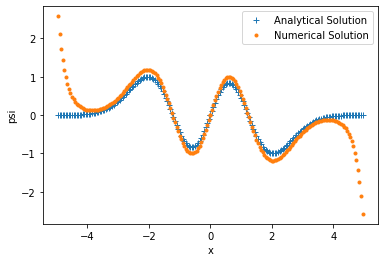

In [302]:
qm = QMosc(0.05,5, 3, 6.99)
qm.plot_an(-1, marker = '+')
qm.plot_num(1, marker = '.')
plt.xlabel('x')
plt.ylabel('psi')
print(qm.eigenvalue(e0 = 7))

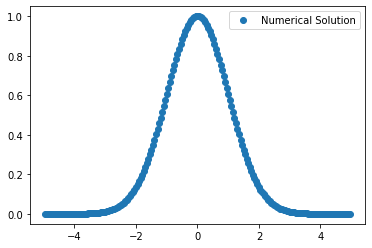

In [287]:
n = 6
qm = QMosc(0.05, 5, 0, 1)
qm.plot_num(1)

In [297]:
#Determining Eigenvalue (a really crude way)
e0 = 4
step = 0.01 
qm = QMosc(0.05, 5, 1, e0)
psi = qm.numeric_solve()
slopeinit = (psi[-1]-psi[-2])/(qm.getdx())
if slopeinit > 0:
    slope = slopeinit
    while slope > 0: 
        slope_before = slope 
        Ecurrent = qm.getE()
        qm.changeE(Ecurrent-step)
        psi = qm.numeric_solve()
        slope = (psi[-1]-psi[-2])/(qm.getdx())
        if abs(slope) > abs(slope_before):
            step = step*-1
else:
    slope = slopeinit
    while slope < 0: 
        slope_before = slope 
        Ecurrent = qm.getE()
        qm.changeE(Ecurrent+step)
        psi = qm.numeric_solve()
        slope = (psi[-1]-psi[-2])/(qm.getdx())
        if abs(slope) > abs(slope_before):
            step = step*-1
print(slopeinit)        
print(qm.getE()) 

-5868.43274328101
2.9900000000000215
